In [60]:
v_infty = 70
rho_a = 0.00237
mu = 2/(10**5)
nu_a = 16.97 /(10**6)
dp = 1
rho_w = 1000
g = 9.81
cylinder_radius = 0.1
from math import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm



In [61]:
# define flow field
# both functions take freestream velocity U, cylinder radius R, and r and theta coords
def vRadial(U, R, r, theta):
    return U*(1 - R**2/r**2)*np.cos(theta)
def vTheta(U, R, r, theta):
    return -U*(1 + R**2/r**2)*np.sin(theta)

In [62]:
# math conversion functions
def cartesianToRadial(x, y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arctan2(x,y)
    return r, theta

def radialToCartesian(r, theta):
    x = r * np.cos(theta) 
    y = r * np.sin(theta)
    return y, x


In [63]:
# droplet trajectory function (mostly from slide 467)

def findcd(Re):
    cd = 24/Re+0.3+6/(1+np.sqrt(Re))
    if cd > 100:
        return cd
    else:
        return 24/Re+0.4+6/(1+np.sqrt(Re))
    
def findRe(V,dp,nu_a):
    return V*dp/nu_a

def findD(cd,rho_a,V_rel,Ap):
    Re = findRe(V_rel, dp, nu_a)
    cd = findcd(Re)
    return cd*rho_a*V_rel**2*Ap/2

def findGamma(V_x_p, V_y_p, V_x_a, V_y_a):
    return atan2(V_y_p - V_y_a, V_x_p - V_x_a)

def findAp(dp):
    return pi*dp**2/4

def findvRel(dx, dy, x, y):
    
    return sqrt((dx - flowsInCartesian(x,y)[0])**2 + (dy - flowsInCartesian(x,y)[1])**2)

def flowsInCartesian(x, y):
    r = cartesianToRadial(x, y)[0]
    theta = cartesianToRadial(x, y)[1]
    
    flowVR = vRadial(v_infty, cylinder_radius, r, theta)
    flowVTheta = vTheta(v_infty, cylinder_radius, r, theta)
    
    flowVX = flowVR * np.cos(theta) - flowVTheta * np.sin(theta)
    flowVY = flowVR * np.sin(theta) + flowVTheta * np.cos(theta)
    
    return flowVX, flowVY
    
def xdoubledot(x, y, u, w):
    global nu_a
    global dp
    global rho_a
    global rho_w
    
    r = dp/2
    mass = 4/3*pi*r**3*rho_w
    
    V_rel = findvRel(u,w,x,y)
    Re = findRe(V_rel,dp,nu_a)
    cd = findcd(Re)
    gamma = findGamma(u, w, flowsInCartesian(x,y)[0], flowsInCartesian(x,y)[1])
    Ap = findAp(dp)
    D = findD(cd, rho_a, V_rel, Ap)
    return (-D * cos(gamma)/mass)

def ydoubledot(x, y, u, w):
    global nu_a
    global dp
    global rho_a
    global rho_w
    
    r = dp/2
    mass = 4/3*pi*r**3*rho_w
    
    V_rel = findvRel(u,w,x,y)
    Re = findRe(V_rel,dp,nu_a)
    cd = findcd(Re)
    gamma = findGamma(u, w, flowsInCartesian(x,y)[0], flowsInCartesian(x,y)[1])
    Ap = findAp(dp)
    D = findD(cd, rho_a, V_rel, Ap)
    
    return (-D * sin(gamma)/mass - g)




In [64]:
def computeParticalTrajectory(xInitial, yInitial, dropletDiameter):
    global nu_a
    global dp
    global rho_a
    
    t = 0
    tFinish = 0.1
    step = 0.001

    # initial droplet position
    y = yInitial
    x = xInitial

    exes = [x]
    eyes = [y]

    # initial droplet velocities are zero
    dxdt = 0
    dydt = 0

    u = dxdt
    v = dydt
    
    dp = dropletDiameter

    # m dx^2/d^2t = -D cos gamma + mg sin alpha = -D cos gamma + mg (for 0 angle of attack)
    # m dy^2/d^2t = -D sin gamma - mg cos alpha = -D sin gamma (for 0 angle of attack)

    for i in range(0,int(tFinish/step)):  
        kx1 = u*step
        ky1 = v*step
        ku1 = xdoubledot(x,y,u,v)*step
        kv1 = ydoubledot(x,y,u,v)*step

        kx2 = (u + ku1/2)*step
        ky2 = (v + kv1/2)*step
        ku2 = xdoubledot(x+kx1/2, y+ky1/2, u+ku1/2, v+kv1/2)*step
        kv2 = ydoubledot(x+kx1/2, y+ky1/2, u+ku1/2, v+kv1/2)*step
        
        kx3 = (u + ku2/2)*step
        ky3 = (v + kv2/2)*step
        ku3 = xdoubledot(x+kx2/2, y+ky2/2, u+ku2/2, v+kv2/2)*step
        kv3 = ydoubledot(x+kx2/2, y+ky2/2, u+ku2/2, v+kv2/2)*step

        kx4 = (u + ku3)*step
        ky4 = (v + kv3)*step
        ku4 = xdoubledot(x+kx3, y+ky3, u+ku3, v+kv3)*step
        kv4 = ydoubledot(x+kx3, y+ky3, u+ku3, v+kv3)*step

        x = x + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
        y = y + (ky1 + 2*ky2 + 2*ky3 + ky4)/6
        u = u + (ku1 + 2*ku2 + 2*ku3 + ku4)/6
        v = v + (kv1 + 2*kv2 + 2*kv3 + kv4)/6

        exes.append(x)
        eyes.append(y)
        r, theta = cartesianToRadial(x, y)
        
        if r > cylinder_radius + 10:
            step = 0.015
        elif r > cylinder_radius + 0.5:
            step = 0.003
        elif r > cylinder_radius:
            step = 0.0005
        else:
            break
        
    return exes, eyes, r, theta
  

In [65]:
def getBetas(thetas):
    realThetas = [t + pi/2 for t in thetas]
    steps = 15
    betas = []
    singleSurfaceLength = pi/steps*cylinder_radius
    locations = np.arange(-pi/2, pi/2 - pi/steps, pi/steps) 
    for location in locations:
        trajectoriesInBucket = [i for i in realThetas if i > location and i <= (location+pi/2/steps)]
        betas.append(len(trajectoriesInBucket))

    realBetas = [x / (pi/steps*cylinder_radius*particleDensity) for x in betas]
    bucketSOverCs = [s / 2 for s in locations]
    return realBetas, bucketSOverCs


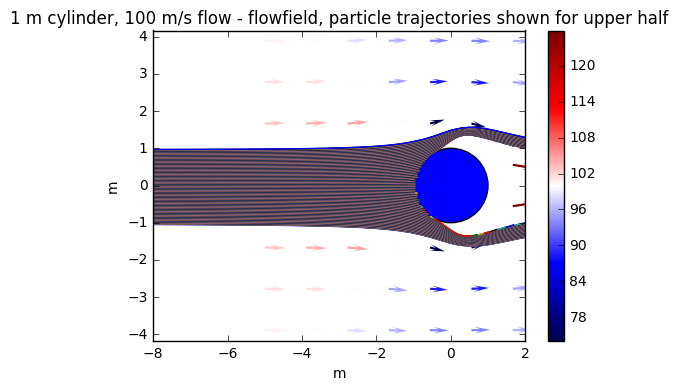

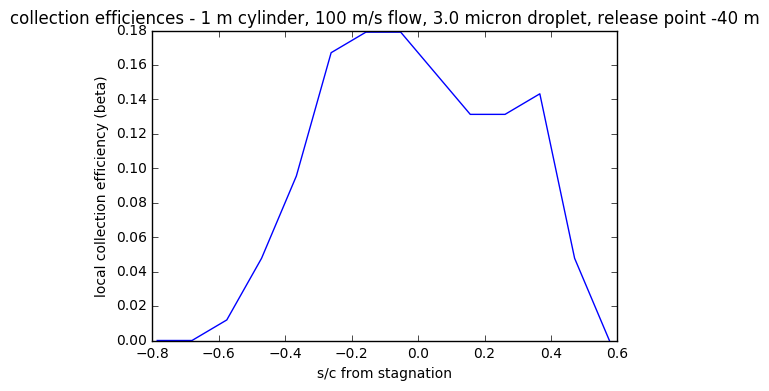

In [70]:
# compute beta
mvd = 3/10**6
resolution = 800
cylinder_radius = 1
v_infty = 100
lowerBound = -cylinder_radius
upperBound = cylinder_radius
plotting = True

if plotting:
    plot2 = plt.figure()
    plt.ylabel('Particle Trajectory')
    plt.ylim([-3.5, 3.5])
    plt.xlim([-8, 2])
    plt.axes().set_aspect('equal', 'datalim')

rs = []
thetas = []

particleDensity = resolution/(upperBound - lowerBound)

releasePoint = -40

for i in np.arange(lowerBound, upperBound, (upperBound - lowerBound)/resolution*2):
    xs, ys, r, theta = computeParticalTrajectory(releasePoint,i,mvd)
    rs.append(r)
    thetas.append(theta)
    if plotting:
        plt.plot(xs, ys)

if plotting:
    plt.xlabel("m")
    plt.ylabel("m")
    circle = plt.Circle((0, 0), radius=cylinder_radius, fc='b')
    plt.gca().add_patch(circle)
    plt.title(str(cylinder_radius) + " m cylinder, 100 m/s flow - flowfield, particle trajectories shown for upper half")

    X, Y = np.mgrid[-5:5:10j, -5:5:10j]
    U = flowsInCartesian(X, Y)[0]
    V = flowsInCartesian(X, Y)[1]

    plt.quiver(X, Y, U, V,        # data
               U,                   # colour the arrows based on this array
               cmap=cm.seismic,     # colour map
               headlength=7)        # length of the arrows
    plt.colorbar()                  # adds the colour bar


    plt.show(plot2)

plot3 = plt.figure()
betas, SoverCs = getBetas(thetas)
plt.xlabel("s/c from stagnation")
plt.ylabel("local collection efficiency (beta)")
plt.title("collection efficiences - " + str(cylinder_radius) + " m cylinder, " + str(v_infty) + " m/s flow, " + str(dp*10**6) + " micron droplet, release point " + str(releasePoint) + " m")
plt.plot(SoverCs, betas)
plt.show(plot3)

In [ ]:
plot1 = plt.figure()
plt.ylabel('Particle Trajectory')
plt.ylim([-3.5, 3.5])
plt.xlim([-5, 2])
plt.axes().set_aspect('equal', 'datalim')

a = []
b = []
# for i in range(1,5):
# xs, ys = computeParticalTrajectory(-30,0.9,5/(10**6))

# a = a + xs
# b = b + ys

# plt.plot(a, b)

xss, yss = computeParticalTrajectory(-30,0.6,5/(10**6))

a = []
b = []

a = a + xss
b = b + yss
plt.plot(a, b)

xss, yss = computeParticalTrajectory(-30,0.5,5/(10**6))

a = []
b = []

a = a + xss
b = b + yss
plt.plot(a, b)


X, Y = np.mgrid[-5:5:10j, -5:5:10j]
U = flowsInCartesian(X, Y)[0]
V = flowsInCartesian(X, Y)[1]

plt.plot(a, b)

plt.quiver(X, Y, U, V,        # data
           U,                   # colour the arrows based on this array
           cmap=cm.seismic,     # colour map
           headlength=7)        # length of the arrows
plt.colorbar()                  # adds the colour bar

circle = plt.Circle((0, 0), radius=cylinder_radius, fc='b')
plt.gca().add_patch(circle)

plt.show(plot1)

